In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/nobackup/sbhusha1/sw/miniconda3/envs/bhushan_PY3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from imview import pltlib
from pygeotools.lib import geolib,malib,warplib,iolib
import pandas as pd 
import os,sys,glob
import subprocess
from multiprocessing import Pool, cpu_count
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import rasterio
import shapely
import gdal
import matplotlib

In [3]:
master_fig_dir = '/nobackup/sbhusha1/skysat_manuscript/figures/'
universal_fig_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0.1}

### plotting functions

In [4]:
def get_clim(ar,full_stretch=False):
    if full_stretch:
        try:
            clim = (np.ma.min(ar),np.ma.max(ar))
        except:
            clim = (np.min(ar),np.max(ar))
    else:
        try:
            clim = np.percentile(ar.compressed(),(2,98))
        except:
            clim = np.percentile(ar,(2,98))
    return clim
def find_common_clim(im1,im2):
    perc1 = get_clim(im1)
    perc2 = get_clim(im2)
    perc = (np.min([perc1[0],perc2[0]]),np.max([perc1[1],perc2[1]]))
    abs_max = np.max(np.abs(perc))
    perc = (-abs_max,abs_max)
    return perc
def fn_2_ma(fn,b=1):
    ds = rasterio.open(fn)
    ar = ds.read(b)
    ndv = get_ndv(ds)
    ma_ar = np.ma.masked_less_equal(ar,ndv)
    return ma_ar
def get_ndv(ds):
    no_data = ds.nodatavals[0]
    if no_data == None:
        #this means no data is not set in tif tag, nead to cheat it from raster
        ndv = ds.read(1)[0,0]
    else:
        ndv = no_data
    return ndv
def plot_ar(im,ax,clim,cmap=None,label=None,cbar=True,alpha=1,extent=None):
    if cmap:
        img = ax.imshow(im,cmap=cmap,clim=clim,alpha=alpha,extent=extent)
    else:
        img = ax.imshow(im,clim=clim,alpha=alpha)
    if cbar:
        divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #cax = divider.append_axes("right", size="5%", pad="2%")
        cax = divider.append_axes("right", size="2%", pad="1%")
        cb = plt.colorbar(img,cax=cax,ax=ax,extend='both')
        cax.set_ylabel(label)

### geogrid function

In [5]:
def cust_range(*args, rtol=1e-05, atol=1e-08, include=[True, False]):
   #### from here https://stackoverflow.com/questions/50299172/python-range-or-numpy-arange-with-end-limit-include
    """
    Combines numpy.arange and numpy.isclose to mimic
    open, half-open and closed intervals.
    Avoids also floating point rounding errors as with
    >>> numpy.arange(1, 1.3, 0.1)
    array([1. , 1.1, 1.2, 1.3])

    args: [start, ]stop, [step, ]
        as in numpy.arange
    rtol, atol: floats
        floating point tolerance as in numpy.isclose
    include: boolean list-like, length 2
        if start and end point are included
    """
    # process arguments
    if len(args) == 1:
        start = 0
        stop = args[0]
        step = 1
    elif len(args) == 2:
        start, stop = args
        step = 1
    else:
        assert len(args) == 3
        start, stop, step = tuple(args)

    # determine number of segments
    n = (stop-start)/step + 1

    # do rounding for n
    if np.isclose(n, np.round(n), rtol=rtol, atol=atol):
        n = np.round(n)

    # correct for start/end is exluded
    if not include[0]:
        n -= 1
        start += step
    if not include[1]:
        n -= 1
        stop -= step

    return np.linspace(start, stop, int(n))

def crange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, True])

def orange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, False])

from pyproj import Proj, transform
from matplotlib.ticker import FormatStrFormatter
## modified by David
def plot_geo_grid(ax,lat_in=5.0,lon_in=5.0,in_proj={'init':'epsg:3857'}, fmt='%0.1f', grid=False,ne_label=True,maintain_extent = True, verbose=False):
    """
    plot geogragriphical grid on axes with projected coordinates
    Inputs are ax object, latitude interval, longitude interval, assumed input projection is epsg:3857
    """
    #Get input axes limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    #Define input and output projections
    in_proj = Proj(in_proj)
    out_proj = Proj(init='epsg:4326')

    #Get lat/lon coord for lower left and upper right mapped coords
    ll = transform(in_proj, out_proj, xlim[0], ylim[0])
    lr = transform(in_proj, out_proj, xlim[1], ylim[0])
    ul = transform(in_proj, out_proj, xlim[0], ylim[1])
    ur = transform(in_proj, out_proj, xlim[1], ylim[1])
    
    #Get number of expected lat or lon intervals
    nx = np.floor((lr[0] - ll[0])/lon_in)
    ny = np.floor((ul[1] - ll[1])/lat_in)
    
    #Determine rounded lower left
    ll_r = np.zeros(2)
    ll_r[0] = lon_in * np.ceil(ll[0]/lon_in)
    ll_r[1] = lat_in * np.ceil(ll[1]/lat_in)
    
    #Calculate rounded upper right
    ur_r = ((ll_r[0] + nx * lon_in), (ll_r[1] + ny * lat_in))
    
    #Prepare lists of rounded coordinates at given intervals
    x_list = np.arange(ll_r[0],ur_r[0]+lon_in,lon_in)
    y_list = np.arange(ll_r[1],ur_r[1]+lat_in,lat_in)
    print(x_list)
    if maintain_extent:
        x_list = crange(ll_r[0],ur_r[0],lon_in)
        y_list = crange(ll_r[1],ur_r[1],lat_in)
    print(ur_r[0])
    print(x_list)
    x_tick_loc_out = list(zip(x_list, np.repeat(ll[1],x_list.size)))
    y_tick_loc_out = list(zip(np.repeat(ll[0],y_list.size), y_list))
    
    #Determine tick locations (in input crs) for the desired lat/lon coords
    x_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[0] for xy in x_tick_loc_out])
    y_tick_loc_init = np.array([transform(out_proj, in_proj, xy[0], xy[1])[1] for xy in y_tick_loc_out])
    
   # verbose = False
    if verbose:
        print(x_tick_loc_out)
        print(x_tick_loc_init)
        print(y_tick_loc_out)
        print(y_tick_loc_init)
    
    #Set formatter
    #ax.xaxis.set_major_formatter(FormatStrFormatter(fmt))
    #ax.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    
    #Prepare tick labels with desired format
    if ne_label:
        x_tick_labels = [fmt % x +'$^\circ$E' for x in x_list]
        y_tick_labels = [fmt % y +'$^\circ$N' for y in y_list]
        x_label = 'Longitude'
        y_label = 'Latitude'
    else:
        x_tick_labels = ['{:.2f}'.format(np.round(x,2)) for x in x_list]
        y_tick_labels = ['{:.2f}'.format(np.round(y,2)) for y in y_list]
        print(x_list)
        print(x_tick_labels)
        x_label = 'Longitude ($^\circ$E)'
        y_label = 'Latitude ($^\circ$N)'
    ax.set_xticks(x_tick_loc_init)
    ax.set_xticklabels(x_tick_labels, minor=False)
    ax.set_yticks(y_tick_loc_init)
    ax.set_yticklabels(y_tick_labels, minor=False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if grid:
        ax.grid(ls=':')

### Figure 1

In [4]:
out_folder = '/nobackup/sbhusha1/skysat/proc_rainier/mapproject_agu'
zoomin_for = '/nobackup/sbhusha1/skysat/triplet_st_helens/20190827_214711_ssc9d2_0010_basic_panchromatic_dn.tif'
zoomin_nadir = '/nobackup/sbhusha1/skysat/triplet_st_helens/20190827_214745_ssc9d2_0011_basic_panchromatic_dn.tif'
zoomin_aft = '/nobackup/sbhusha1/skysat/triplet_st_helens/20190827_214821_ssc9d2_0010_basic_panchromatic_dn.tif'
zoomin_for_map = glob.glob(os.path.join(out_folder,os.path.splitext(os.path.basename(zoomin_for))[0]+'*map.tif'))[0]
zoomin_nadir_map = glob.glob(os.path.join(out_folder,os.path.splitext(os.path.basename(zoomin_nadir))[0]+'*map.tif'))[0]
zoomin_aft_map = glob.glob(os.path.join(out_folder,os.path.splitext(os.path.basename(zoomin_aft))[0]+'*map.tif'))[0]

In [6]:
ds_list = warplib.memwarp_multi_fn([zoomin_aft_map,zoomin_for_map,zoomin_nadir_map],extent='union')


Warping all inputs to the following:
Resolution: 0.8240606188774109
Extent: [585823.8244496286, 5188183.867066652, 588621.700334698, 5190106.11309126]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 3: /nobackup/sbhusha1/skysat/proc_rainier/mapproject_agu/20190827_214821_ssc9d2_0010_basic_panchromatic_dn_map.tif
nl: 2333 ns: 3395 res: 0.824
2 of 3: /nobackup/sbhusha1/skysat/proc_rainier/mapproject_agu/20190827_214711_ssc9d2_0010_basic_panchromatic_dn_map.tif
nl: 2333 ns: 3395 res: 0.824
3 of 3: /nobackup/sbhusha1/skysat/proc_rainier/mapproject_agu/20190827_214745_ssc9d2_0011_basic_panchromatic_dn_map.tif
nl: 2333 ns: 3395 res: 0.824


<IPython.core.display.Javascript object>


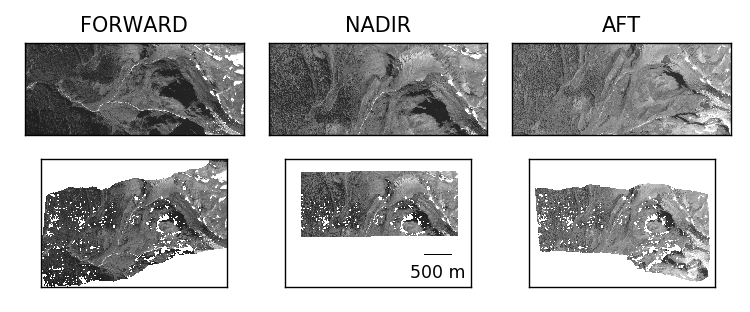

In [7]:
fig,ax = plt.subplots(2,3,figsize=(6,2.5))
#plt.style.use('dark_background')
axa = ax.ravel()
rainier_triplet_map_clim = (0,650)
axa[3].imshow(iolib.ds_getma(ds_list[1]),cmap='gray',clim=rainier_triplet_map_clim)
axa[4].imshow(iolib.ds_getma(ds_list[2]),cmap='gray',clim=rainier_triplet_map_clim)
axa[5].imshow(iolib.ds_getma(ds_list[0]),cmap='gray',clim=rainier_triplet_map_clim)
scalebar = ScaleBar(1.0,location='lower right')
axa[4].add_artist(scalebar)
axa[0].imshow(iolib.fn_getma(zoomin_for),cmap='gray',clim=rainier_triplet_map_clim)
axa[1].imshow(iolib.fn_getma(zoomin_nadir),cmap='gray',clim=rainier_triplet_map_clim)
axa[2].imshow(iolib.fn_getma(zoomin_aft),cmap='gray',clim=rainier_triplet_map_clim)
axa[0].set_title('FORWARD')
axa[1].set_title('NADIR')
axa[2].set_title('AFT')
for i,axa in enumerate(ax.ravel()):
    axa.set_xticks([])
    axa.set_yticks([])
plt.tight_layout()
fig.savefig('../agu/Triplet_perspective_white_bg.jpg',dpi=400,pad_inches=0.1,bbox_inches='tight')

### Figure 2

In [22]:
#map_img = '/nobackup/sbhusha1/skysat/proc_rainier/after_dense_ba_mapproject_stereo_pairs_only/nadir_mapproject.tif'
map_img = '/nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/aligned_2_wv_orthomosaics/214711_214745_214821_finest_orthomosaic.tif'
dem_fn = glob.glob('/nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/run-trans_reference-DEM.tif')[0]
same_extent = 'True'
rainier_triplet_map_clim = (0,650)
if same_extent:
    ds_list = warplib.memwarp_multi_fn([map_img,dem_fn],extent='union',res='max')
    map_ma = iolib.ds_getma(ds_list[0])
    dem_ma = iolib.ds_getma(ds_list[1])
    extent = geolib.ds_extent(ds_list[0])
    extent = [extent[0],extent[2],extent[1],extent[3]]
else:
    map_ds = iolib.fn_getds(map_img)
    map_ma = iolib.ds_getma(map_ds)
    dem_ds = iolib.fn_getds(dem_fn)
    dem_ma = iolib.ds_getma(dem_ds)
    extent = geolib.ds_extent(map_ds)
    extent = [extent[0],extent[2],extent[1],extent[3]]


Warping all inputs to the following:
Resolution: 2.0
Extent: [583557.0, 5175797.0, 591055.066856712, 5199157.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/aligned_2_wv_orthomosaics/214711_214745_214821_finest_orthomosaic.tif
nl: 11680 ns: 3749 res: 2.000
2 of 2: /nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/run-trans_reference-DEM.tif
nl: 11680 ns: 3749 res: 2.000


In [130]:
producttype = 'hillshade'
hs_rainier_ds = gdal.DEMProcessing('',ds_list[1],producttype,format='MEM')
hs_rainier = hs_rainier_ds.ReadAsArray()

<IPython.core.display.Javascript object>


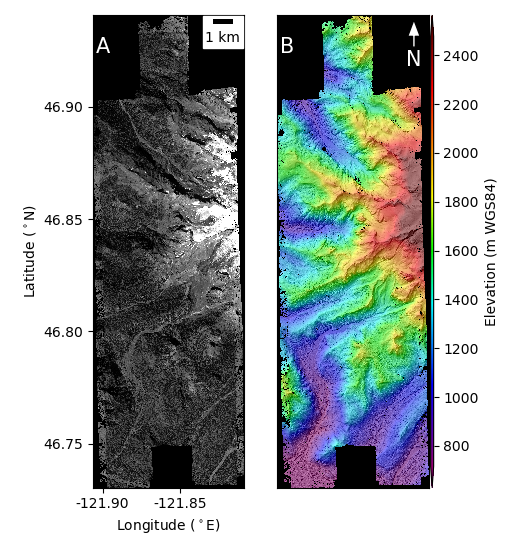

[-121.9  -121.85]
-121.85000000000001
[-121.9  -121.85]
[(-121.9, 46.73050072758819), (-121.85000000000001, 46.73050072758819)]
[584047.40155365 587867.70837661]
[(-121.90641834934857, 46.75), (-121.90641834934857, 46.8), (-121.90641834934857, 46.85), (-121.90641834934857, 46.900000000000006), (-121.90641834934857, 46.95)]
[5177963.76122792 5183519.79921959 5189075.88420749 5194632.01618708
 5200188.19515368]
[-121.9  -121.85]
['-121.90', '-121.85']
(66.56829, 1826.0944)


In [23]:
fig,ax = plt.subplots(1,2,figsize=(5.2,5.5))
#pltlib.iv(map_ma,ds=map_ds,ax=ax[0],scalebar=True,label='DN',cmap='gray')
peak_im = ax[0].imshow(map_ma,extent=extent,cmap='gray',clim=(80,650))
plot_geo_grid(ax[0],0.05,0.05,in_proj={'init':'epsg:32610'},ne_label=False,verbose=True,maintain_extent=True)
ax[0].set_xlim(extent[0],extent[1])
ax[0].set_ylim(extent[2],extent[3])
print(get_clim(map_ma,full_stretch=True))

scalebar = ScaleBar(1.0)
ax[0].set_aspect('equal')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="2%", pad=0.5)
#cax = divider.append_axes("right", size="2%", pad="2%")
#cax = divider.append_axes("right", size="2%", pad="1%")
cb = plt.colorbar(peak_im,cax=cax)
cb.remove()


pltlib.iv(dem_ma,ds=ds_list[1],ax=ax[1],scalebar=False,hillshade=True,label='Elevation (m WGS84)')



x, y, arrow_length = 0.9, 0.99, 0.085
ax[1].annotate('N', color='white',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', width=2, headwidth=9),
            ha='center', va='center', fontsize=15,
            xycoords=ax[1].transAxes)
ax[0].add_artist(scalebar)
ax[0].text(0.020,0.92,'A',
    color='white', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.92,'B',
    color='white', fontsize=15,transform=ax[1].transAxes)

plt.tight_layout()
outfig = os.path.join(master_fig_dir,'Figure3.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])

#plt.tight_layout()

#fig.savefig('../agu/triplet_ortho_dem_full.jpg',dpi=300,pad_inches=0.1,bbox_inches='tight')
#bring the text some buffer

In [17]:
ax[0].get_xlim()

(583557.0, 591055.0)

In [43]:
ylima

(5858.5, -0.5)

In [45]:
xlima

(-0.5, 1869.5)

### Figure 3

In [24]:
count_fn = '/nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/composite_dems/total_composite_count.tif'
nmadpre_fn = '/nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/rpc_freshmap_mgm/composite_dems/total_composite_nmad.tif'
nmadpost_fn = '/nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/composite_dems/total_composite_nmad.tif'
dhpre_fn = '/nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/rpc_freshmap_mgm/align_wv/rainier_allgood_mos-tile-0_run-trans_reference-DEM_diff.tif'
dhpost_fn = '/nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/rainier_allgood_mos-tile-0_run-trans_reference-DEM_diff.tif'
same_extent = True
if same_extent:
    ds_list = warplib.memwarp_multi_fn([count_fn,nmadpre_fn,nmadpost_fn,dhpre_fn,dhpost_fn],extent='first',res='max')
    count = iolib.ds_getma(ds_list[0])
    nmadpre = iolib.ds_getma(ds_list[1])
    nmadpost = iolib.ds_getma(ds_list[2])
    dhpre = iolib.ds_getma(ds_list[3])
    dhpost = iolib.ds_getma(ds_list[4])
    extent = geolib.ds_extent(ds_list[0])
    extent = [extent[0],extent[2],extent[1],extent[3]]


Warping all inputs to the following:
Resolution: 8.46180384560113
Extent: [583559.0, 5175799.0, 591055.0, 5199157.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 5: /nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/composite_dems/total_composite_count.tif
nl: 2760 ns: 886 res: 8.462
2 of 5: /nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/rpc_freshmap_mgm/composite_dems/total_composite_nmad.tif
nl: 2760 ns: 886 res: 8.462
3 of 5: /nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/composite_dems/total_composite_nmad.tif
nl: 2760 ns: 886 res: 8.462
4 of 5: /nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/rpc_freshmap_mgm/align_wv/rainier_allgood_mos-tile-0_run-trans_reference-DEM_diff.tif
nl: 2760 ns: 886 res: 8.462
5 of 5: /nobackup/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/align_wv/rainier_allgood_

In [25]:
from demcoreg import dem_mask

In [26]:
def get_nlcd(dem_ds):
    rs = 'near'
    nlcd_ds = gdal.Open(dem_mask.get_nlcd_fn())
    nlcd_ds_warp = warplib.memwarp_multi([nlcd_ds,], res=dem_ds, extent=dem_ds, t_srs=dem_ds, r=rs)[0]
    nlcd_mask = dem_mask.get_nlcd_mask(nlcd_ds_warp,filter='not_forest')
    return nlcd_mask

<IPython.core.display.Javascript object>


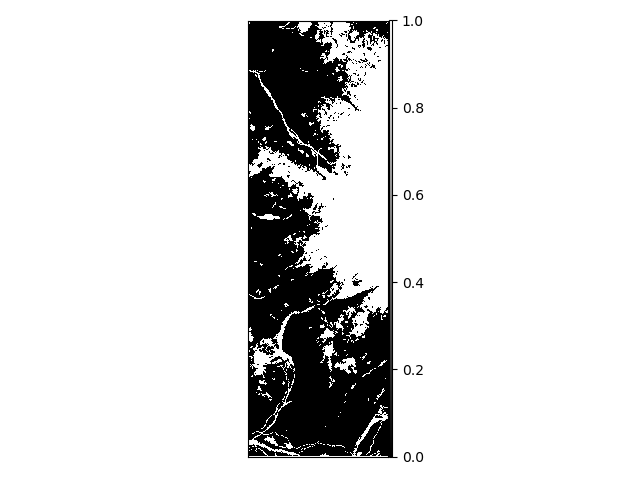


Warping all inputs to the following:
Resolution: 8.46180384560113
Extent: [583559.0, 5175802.421386141, 591056.1582072026, 5199157.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: near

1 of 1: /nobackup/sbhusha1/reference_data/NLCD_2016_Land_Cover_L48_20190424.tif
nl: 2760 ns: 886 res: 8.462
Loading NLCD LULC
Filtering NLCD LULC with: not_forest


In [27]:
f,ax = plt.subplots()
not_forest_mask = get_nlcd(ds_list[4])
pltlib.iv(not_forest_mask,ax=ax,cmap='gray')

<IPython.core.display.Javascript object>


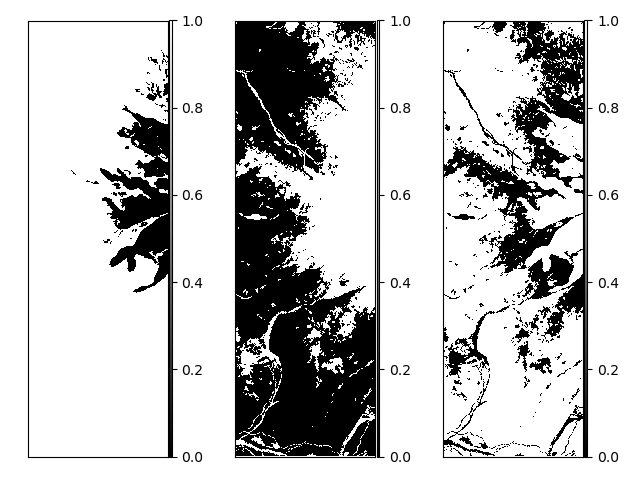

Masking glaciers
Found glacier shp: /nobackup/sbhusha1/reference_data/rgi60/regions/rgi60_merge.shp
Input shp srs: +proj=longlat +datum=WGS84 +no_defs 
Specified output srs: +proj=utm +zone=10 +datum=WGS84 +units=m +no_defs 

Warping all inputs to the following:
Resolution: 8.46180384560113
Extent: [583559.0, 5175802.421386141, 591056.1582072026, 5199157.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: near

1 of 1: /nobackup/sbhusha1/reference_data/NLCD_2016_Land_Cover_L48_20190424.tif
nl: 2760 ns: 886 res: 8.462
Loading NLCD LULC
Filtering NLCD LULC with: not_forest


In [28]:
f,ax = plt.subplots(1,3)
ice_mask = dem_mask.get_icemask(ds_list[4])
pltlib.iv(ice_mask,ax=ax[0],cmap='gray')
not_forest_mask = get_nlcd(ds_list[4])
pltlib.iv(not_forest_mask,ax=ax[1],cmap='gray')
pltlib.iv(~np.logical_and(ice_mask,not_forest_mask),ax=ax[2],cmap='gray')
vegetated_mask = ~np.logical_and(ice_mask,not_forest_mask)

<IPython.core.display.Javascript object>


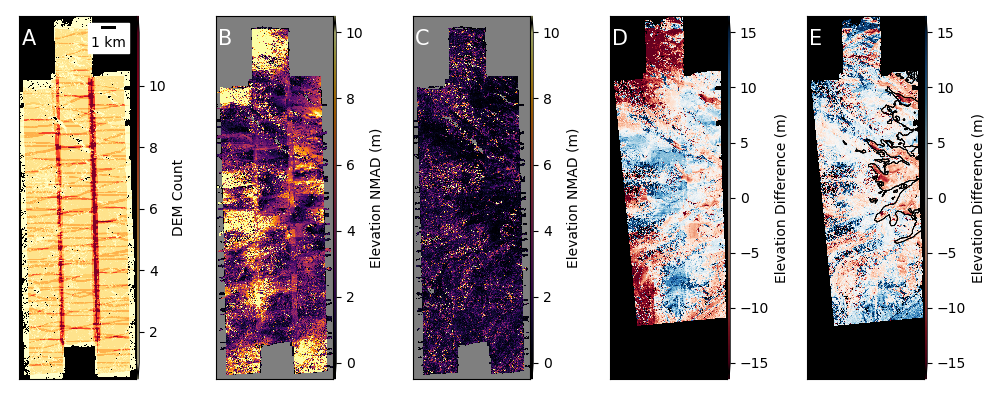

In [65]:
cmap_count = 'YlOrRd'
cmap_nmad = 'inferno'
clim_nmad = (0,10)
dh_cmap = 'RdBu'
clim_dh = (-15,15)
fig,ax = plt.subplots(1,5,figsize=(10,4))
title_list = ['Count map','Relative Accuracy \n Planet RPC','Relative Accuracy \n Refined Camera','Planet RPC DEM \n vs \n WV DEM','Refined Pinhole DEM \n vs \n WV DEM']
pltlib.iv(count,ds=ds_list[0],ax=ax[0],scalebar=True,label='DEM Count',cmap=cmap_count)
pltlib.iv(nmadpre,ax=ax[1],label='Elevation NMAD (m)',clim=clim_nmad,cmap=cmap_nmad)
pltlib.iv(nmadpost,ax=ax[2],label='Elevation NMAD (m)',clim=clim_nmad,cmap=cmap_nmad)
pltlib.iv(dhpre,ax=ax[3],clim=clim_dh,cmap=dh_cmap,label='Elevation Difference (m)')
pltlib.iv(dhpost,ax=ax[4],clim=clim_dh,cmap=dh_cmap,label='Elevation Difference (m)')

#ax[4].contour(vegetated_mask,colors='green',linewidths=0.05)
# vegetated mask does not make sense now, excluded that

ax[4].contour((ice_mask),colors='k',linewidths=0.35)
plt.tight_layout(pad=-0.1, w_pad=0.2, h_pad=0.2)
xlima = ax[0].get_xlim()
ylima = ax[0].get_ylim()
ax[0].text(0.020,0.92,'A',
    color='white', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.92,'B',
    color='white', fontsize=15,transform=ax[1].transAxes)
ax[2].text(0.020,0.92,'C',
    color='white', fontsize=15,transform=ax[2].transAxes)
ax[3].text(0.020,0.92,'D',
    color='white', fontsize=15,transform=ax[3].transAxes)
ax[4].text(0.020,0.92,'E',
    color='white', fontsize=15,transform=ax[4].transAxes)
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'Figure4.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])

# give some buffer, change caption to DEM Difference to make it more intuitive

<IPython.core.display.Javascript object>


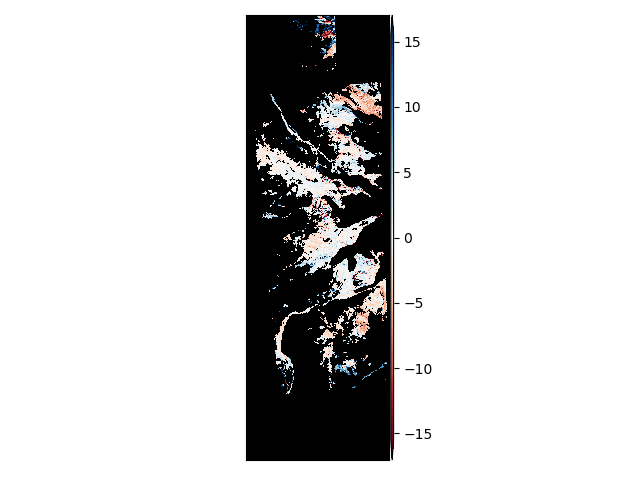

In [70]:
non_glac_vegetated_dh = np.ma.array(dhpost,mask=vegetated_mask)
f,ax = plt.subplots()
pltlib.iv(non_glac_vegetated_dh,cmap='RdBu',ax=ax,clim=malib.calcperc_sym(non_glac_vegetated_dh,(2,98)))

In [71]:
malib.get_stats_dict(non_glac_vegetated_dh)

{'count': 448249,
 'min': -811.767333984375,
 'max': 1725.487060546875,
 'ptp': 2537.25439453125,
 'mean': 0.07635245334774818,
 'std': 6.938209720584357,
 'nmad': 2.39765137796402,
 'med': -0.195711150765419,
 'median': -0.195711150765419,
 'p16': -2.926089420318603,
 'p84': 2.4164442729949953,
 'spread': 2.671266846656799,
 'mode': -2.1564781665802}

### Figure 4

In [6]:
def fix_polygon_wkt(string):
    # from Scott Henderson's notebook
    '''returns shapely geometry from reformatted WKT'''
    pre = string[:-2]
    first_point = string.split(',')[0].split('(')[-1]
    fixed = f'{pre},{first_point}))'
    return shapely.wkt.loads(fixed)
def parse_frame_index(frame_index):
    df = pd.read_csv(frame_index)
    geo_crs = {'init': 'epsg:4326'}
    df['geom'] = df['geom'].apply(fix_polygon_wkt)
    gdf = gpd.GeoDataFrame(df, geometry='geom', crs=geo_crs)
    return gdf
def convergence_angle(az1, el1, az2, el2):
    # from David's dgtools
    conv_ang = np.rad2deg(
        np.arccos(
            np.sin(
                np.deg2rad(el1)) *
            np.sin(
                np.deg2rad(el2)) +
            np.cos(
                np.deg2rad(el1)) *
            np.cos(
                np.deg2rad(el2)) *
            np.cos(
                np.deg2rad(
                    az1 -
                    az2))))
    return conv_ang

In [7]:
df = parse_frame_index('/nobackup/sbhusha1/skysat_video/Mt.St.Helens/output/video/frame_index.csv')
off_nadir = '/nobackup/sbhusha1/skysat_video/Mt.St.Helens/output/video/frames/1239821532.67319083_sc00103_c1_PAN.tiff'
df[df['name'] == os.path.splitext(os.path.basename(off_nadir))[0]]

name                          datetime  \
3142  1239821532.67319083_sc00103_c1_PAN  2019-04-20T18:51:54.673191+00:00   

           gsd   sat_az  sat_elev  x_sat_eci_km  y_sat_eci_km  z_sat_eci_km  \
3142  0.945895  173.752    53.339    4963.54356     834.82503    4675.49696   

        qw_eci    qx_eci  ...    qz_eci  x_sat_ecef_km  y_sat_ecef_km  \
3142  0.621777 -0.036741  ...  0.171475    -2643.07526    -4273.47379   

      z_sat_ecef_km   qw_ecef   qx_ecef   qy_ecef   qz_ecef  bit_dpth  \
3142     4684.60716  0.412268  0.711145  0.281328  0.495138        16   

                                                   geom  
3142  POLYGON ((-122.17300 46.18530, -122.20800 46.1...  

[1 rows x 21 columns]

-122.19153392905524

<IPython.core.display.Javascript object>


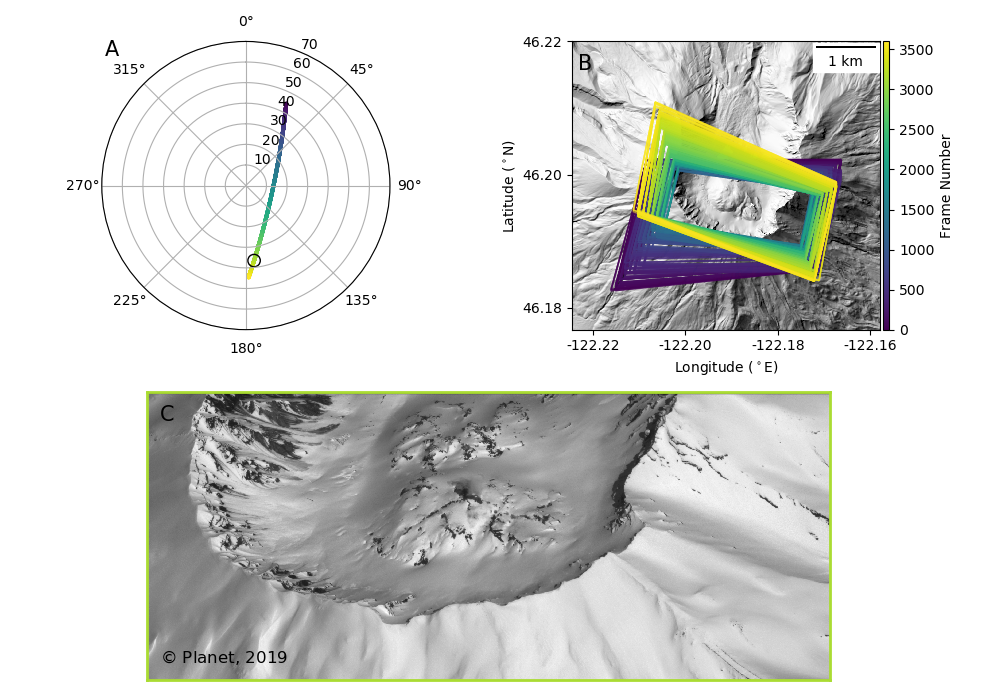

Max conv angle: 85.73
Projection for hillshade is PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
Ground Target Center is (-122.19153392905524, 46.19455892695292)
[-122.22 -122.2  -122.18 -122.16]
-122.16
[-122.22 -122.2  -122.18 -122.16]
[(-122.22, 46.176707963549255), (-122.2, 46.176707963549255), (-122.17999999999999, 46.176707963549255), (-122.16, 46.176707963549255)]
[560204.575968   561748.27912384 563291.98198161 564835.68453384]
[(-122.

In [21]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(nrows=2, ncols=2)
#ax0 = fig.add_subplot(gs[0, 0],polar=True)
ax0 = plt.subplot(G[1, :])
ax1 = plt.subplot(G[0, -2],polar=True)
ax2 = plt.subplot(G[0, -1])
ax1.set_theta_direction(-1)
ax1.set_theta_zero_location('N')
ax1.grid(True)

az = np.deg2rad(df['sat_az'])
el = 90 - df['sat_elev']
ax1.scatter(az, el, c=list(df.index), s=3)

ax1.scatter(az[3142],el[3142],s=80, facecolors='none', edgecolors='k')
ax1.set_rmin(0)
ax1.set_rmax(70)
az1, el1 = df[['sat_az', 'sat_elev']].iloc[0]
az2, el2 = df[['sat_az', 'sat_elev']].iloc[-1]
max_conv = convergence_angle(az1, el1, az2, el2)
print("Max conv angle: %0.2f" % max_conv)
basemap_hs = '/nobackup/sbhusha1/skysat_video/paper_analysis/mos_8m_all_toamask-tile-0_hs.tif'
hs_ds = iolib.fn_getds(basemap_hs)
hs_proj = hs_ds.GetProjection()
print(f"Projection for hillshade is {hs_proj}")
hs_im = iolib.ds_getma(hs_ds)
extent = geolib.ds_extent(hs_ds)
extent = [extent[0],extent[2],extent[1],extent[3]]
ax2.imshow(hs_im,extent=extent,cmap='gray')
print(f"Ground Target Center is {df.unary_union.centroid.x,df.unary_union.centroid.y}")
df = df.to_crs(hs_proj)
total_bounds = df.total_bounds
df['c'] = np.arange(len(df))
df.plot('c',facecolor='None',alpha=0.2,ax=ax2)
sm = plt.cm.ScalarMappable(cmap='viridis',norm=plt.Normalize(vmin=df.c.values.min(), vmax=df.c.values.max()))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
pltlib.add_cbar(ax2,sm,label='Frame Number',cbar_kwargs={'extend':'neither'})
buffer = 650
x_lim = (total_bounds[0]-buffer,total_bounds[2]+buffer)
y_lim = (total_bounds[1]-buffer,total_bounds[3]+buffer)
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
scale = ScaleBar(1.0)
ax2.add_artist(scale)
plot_geo_grid(ax2,0.02,0.02,in_proj={'init':'epsg:32610'},ne_label=False,verbose=True,maintain_extent=True)
### off-nadir frame sextion
### context manager to temporarily change axes border color
ax0.imshow(np.fliplr(iolib.fn_getma(off_nadir)),cmap='gray',origin='lower right')
ax0.set_xticks([])
ax0.set_yticks([])
x_lim0 = ax0.get_xlim()
y_lim0 = ax0.get_ylim()
#num_color_normalised = 3143/3600 # this is for retrieving color from the colormap
norm = matplotlib.colors.Normalize(vmin=0, vmax=3599)
cmap = matplotlib.cm.get_cmap()
color = cmap(norm(3142))
ax0.spines['bottom'].set_color(color)
ax0.spines['bottom'].set_lw(2)
ax0.spines['top'].set_lw(2)
ax0.spines['right'].set_lw(2)
ax0.spines['left'].set_lw(2)
ax0.spines['top'].set_color(color)
ax0.spines['left'].set_color(color)
ax0.spines['right'].set_color(color)
ax0.text(0.02,0.06,'$\copyright$ Planet, 2019',
color='black', fontsize=12,transform=ax0.transAxes)
#plt.text(0.5, 0.5, 'Axes 3', ha='center', va='center', size=24, alpha=.5)
ax0.text(0.020,0.9,'C',color='k', fontsize=15,transform=ax0.transAxes)
ax2.text(0.020,0.9,'B',color='k', fontsize=15,transform=ax2.transAxes)
ax1.text(0.012,0.95,'A',color='k', fontsize=15,transform=ax1.transAxes)
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'Figure2.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])


### Figure 5

In [46]:
data_dir_fall = '/nobackup/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/mapprojected_from_non_map_new_code_sam_interval_10_padding_block_mapped_images_for_further_runs/'
data_dir_peak = '/nobackup/sbhusha1/skysat_video/Mt.St.Helens/output/video/mgm_sam_interval_10_high/'
peak_ortho = '/nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/mgm_sam_interval_10_high/aligned_2_wv_orthomosaics/video_median_orthomosaic.tif'
fall_ortho = '/nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/mapprojected_from_non_map_new_code_sam_interval_10_padding_block_mapped_images_for_further_runs/aligned_2_wv_orthomosaics/video_median_orthomosaic.tif'
peak_fn_list = [os.path.join(data_dir_fall,x) for x in ['median_mos.tif','nmad_mos.tif','count_mos.tif']]
fall_fn_list = [os.path.join(data_dir_peak,x) for x in ['median_mos.tif','nmad_mos.tif','count_mos.tif']]

In [47]:
fn_p_list = [peak_ortho]+peak_fn_list+[fall_ortho]+fall_fn_list
poster_ds_list = warplib.memwarp_multi_fn(fn_p_list,extent='union',res=2)
extent = geolib.ds_extent(poster_ds_list[1])
extent = [extent[0],extent[2],extent[1],extent[3]]


Warping all inputs to the following:
Resolution: 2.0
Extent: [559937.0, 5114377.0, 564283.7808725, 5117827.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 8: /nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/mgm_sam_interval_10_high/aligned_2_wv_orthomosaics/video_median_orthomosaic.tif
nl: 1725 ns: 2173 res: 2.000
2 of 8: /nobackup/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/mapprojected_from_non_map_new_code_sam_interval_10_padding_block_mapped_images_for_further_runs/median_mos.tif
nl: 1725 ns: 2173 res: 2.000
3 of 8: /nobackup/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/mapprojected_from_non_map_new_code_sam_interval_10_padding_block_mapped_images_for_further_runs/nmad_mos.tif
nl: 1725 ns: 2173 res: 2.000
4 of 8: /nobackup/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/mapprojected_from_non_map_new_code_sam_inte

/nobackup/sbhusha1/sw/miniconda3/envs/bhushan_PY3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  del sys.path[0]


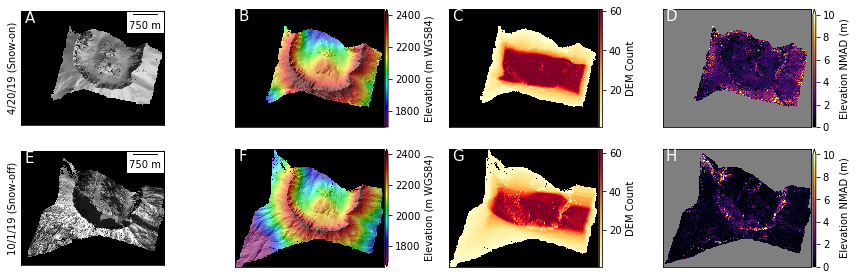

In [48]:
%matplotlib inline
fig,ax = plt.subplots(2,4,figsize=(12,5),constrained_layout=True)
axa = ax.ravel()
#pltlib.iv(iolib.fn_getma(peak_ortho),ax=axa[0],ds=iolib.fn_getds(peak_ortho),scalebar=True,cmap='gray',clim=(0,2500),title='Ortho image')
peak_im = axa[0].imshow(iolib.ds_getma(poster_ds_list[0]),extent=extent,cmap='gray',clim=(0,2500))
#pltlib.add_cbar(axa[0],peak_im)
scalebar = ScaleBar(1.0)
axa[0].add_artist(scalebar)
axa[0].set_xticks([])
axa[0].set_yticks([])
axa[0].set_aspect('equal')
divider = make_axes_locatable(axa[0])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,hspace = 0, wspace = 0)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = divider.append_axes("right", size="5%", pad="2%")
#cax = divider.append_axes("right", size="2%", pad="1%")
cb = plt.colorbar(peak_im,cax=cax)
cb.remove()
clim_dem = (1700,2400)
cmap_count = 'YlOrRd'
cmap_nmad = 'inferno'
title_list = ['Ortho image','Composite Median DEM','Count Map','Relative Accuracy']
#axa[0].set_title()
pltlib.iv(iolib.ds_getma(poster_ds_list[1]),ds=poster_ds_list[1],ax=axa[5],scalebar=False,hillshade=True,label='Elevation (m WGS84)',clim=clim_dem)
pltlib.iv(iolib.ds_getma(poster_ds_list[3]),ax=axa[6],scalebar=False,label='DEM Count',cmap=cmap_count)
pltlib.iv(iolib.ds_getma(poster_ds_list[2]),ax=axa[7],scalebar=False,clim=(0,10),label='Elevation NMAD (m)',cmap=cmap_nmad)
#pltlib.iv(iolib.fn_getma(fall_ortho),ds=iolib.fn_getds(fall_ortho),ax=axa[4],scalebar=True,cmap='gray',clim=(0,2500))
fall_im = axa[4].imshow(iolib.ds_getma(poster_ds_list[4]),extent=extent,cmap='gray',clim=(0,2500))
#pltlib.add_cbar(axa[4],fall_im)
scalebar = ScaleBar(1.0)
axa[4].add_artist(scalebar)
axa[4].set_xticks([])
axa[4].set_yticks([])
divider = make_axes_locatable(axa[4])
#cax = divider.append_axes("right", size="5%", pad=0.05)
cax = divider.append_axes("right", size="5%", pad="2%")
#cax = divider.append_axes("right", size="2%", pad="1%")
cb = plt.colorbar(fall_im,cax=cax)
cb.remove()
pltlib.iv(iolib.ds_getma(poster_ds_list[5]),ds=poster_ds_list[5],ax=axa[1],scalebar=False,hillshade=True,label='Elevation (m WGS84)',clim=clim_dem)
pltlib.iv(iolib.ds_getma(poster_ds_list[7]),ax=axa[2],scalebar=False,label='DEM Count',cmap=cmap_count)
pltlib.iv(iolib.ds_getma(poster_ds_list[6]),ax=axa[3],scalebar=False,clim=(0,10),label='Elevation NMAD (m)',cmap=cmap_nmad)
axa[0].set_ylabel('4/20/19 (Snow-on)')
axa[4].set_ylabel('10/1/19 (Snow-off)')
plt.tight_layout()
xlima = axa[1].get_xlim()
ylima = axa[1].get_ylim()
axa[1].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'B',
    color='white', fontsize=15)
axa[2].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'C',
    color='white', fontsize=15)
axa[3].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'D',
    color='white', fontsize=15)
axa[0].text(extent[0]+100,extent[3]-350,'A',
    color='white', fontsize=15)
axa[5].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'F',
    color='white', fontsize=15)
axa[6].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'G',
    color='white', fontsize=15)
axa[7].text(xlima[0]+0.02*np.ptp(xlima),ylima[1]+0.1*np.ptp(ylima),'H',
    color='white', fontsize=15)
axa[4].text(extent[0]+100,extent[3]-350,'E',
    color='white', fontsize=15)
#plt.subplots_adjust(hspace= 0 , wspace= 0.2)
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,hspace = 0, wspace = 0)
plt.tight_layout()
#plt.subplots_adjust(wspace=0.4, hspace=-0.01)
outfig = os.path.join(master_fig_dir,'Figure5.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])
#universal_fig_opt = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0}

In [16]:
snow_off_nmad = iolib.ds_getma(poster_ds_list[2])
snow_on_nmad = iolib.ds_getma(poster_ds_list[6])

In [17]:
malib.calcperc(snow_off_nmad,(1,99))

(0.03257666155695915, 6.09038782119751)

In [18]:
malib.calcperc(snow_on_nmad,(1,99))

(0.18677285313606262, 8.381091613769552)

In [16]:
malib.get_stats_dict(snow_off_nmad)

{'count': 1844396,
 'min': 0.0007239257683977485,
 'max': 188.59713745117188,
 'ptp': 188.59642028808594,
 'mean': 0.8221054653457536,
 'std': 1.6212104587086504,
 'nmad': 0.3348672376334667,
 'med': 0.44883397221565247,
 'median': 0.44883397221565247,
 'p16': 0.2128341794013977,
 'p84': 1.223434567451477,
 'spread': 0.5053001940250397,
 'mode': 0.26350897550582886}

In [17]:
malib.get_stats_dict(snow_on_nmad)

{'count': 1269873,
 'min': 0.0007239257683977485,
 'max': 35.965354919433594,
 'ptp': 35.964630126953125,
 'mean': 2.0778899613250226,
 'std': 1.688596757662674,
 'nmad': 1.0239207310438156,
 'med': 1.6360722780227661,
 'median': 1.6360722780227661,
 'p16': 0.8267232179641724,
 'p84': 3.227985143661499,
 'spread': 1.2006309628486633,
 'mode': 1.0656187534332275}

In [20]:
slope_snow_off = gdaldem(poster_ds_list[2])
low_slope = slope_snow_off<=15
high_slope = slope_snow_off>15
nmad_snow_off_low_slope = snow_off_nmad[low_slope]
nmad_snow_off_high_slope = snow_off_nmad[high_slope]

In [22]:
malib.get_stats_dict(nmad_snow_off_high_slope)

{'count': 105578,
 'min': 0.0007239257683977485,
 'max': 188.59713745117188,
 'ptp': 188.59642028808594,
 'mean': 3.8010836965345427,
 'std': 4.866903837731465,
 'nmad': 1.911533801937103,
 'med': 2.8544392585754395,
 'median': 2.8544392585754395,
 'p16': 1.3916169834136962,
 'p84': 5.812399864196777,
 'spread': 2.2103914403915406,
 'mode': 2.1515073776245117}

In [23]:
malib.get_stats_dict(nmad_snow_off_low_slope)

{'count': 1738818,
 'min': 0.0007239257683977485,
 'max': 171.38653564453125,
 'ptp': 171.3858184814453,
 'mean': 0.6412270964236174,
 'std': 0.8821238464276642,
 'nmad': 0.29944860321879385,
 'med': 0.4249444305896759,
 'median': 0.4249444305896759,
 'p16': 0.20631884038448334,
 'p84': 1.0134960412979126,
 'spread': 0.40358860045671463,
 'mode': 0.26350897550582886}

In [25]:
nmad_snow_on_low_slope = snow_on_nmad[low_slope]

In [26]:
malib.get_stats_dict(nmad_snow_on_low_slope)

{'count': 1191920,
 'min': 0.0007239257683977485,
 'max': 35.965354919433594,
 'ptp': 35.964630126953125,
 'mean': 2.067790138389158,
 'std': 1.6690402745140585,
 'nmad': 1.0174812203407286,
 'med': 1.6360722780227661,
 'median': 1.6360722780227661,
 'p16': 0.8281710743904114,
 'p84': 3.2040956020355225,
 'spread': 1.1879622638225555,
 'mode': 1.356636881828308}

In [58]:
def plot_video_out(ds_list,axes,clim=None):
    """
    Plot video outputs over axes provided
    Parameters
    -----------
    ds_list: list
        list of gdal dataset list
    axes: list
        list of axes (4) over which images are to be plotted
    clim: tuple
        range for orhtoimage
    """
    cmap_nmad ='inferno'
    cmap_count = 'YlOrRd'
    extent = geolib.ds_extent(ds_list[0])
    extent = [extent[0],extent[2],extent[1],extent[3]]
    if not clim:
        clim = malib.calcperc(iolib.ds_getma(ds_list[0]),(2,98))
    fall_im = axes[0].imshow(iolib.ds_getma(ds_list[0]),extent=extent,cmap='gray',clim=clim)
    #pltlib.add_cbar(axa[4],fall_im)
    scalebar = ScaleBar(1.0)
    axes[0].add_artist(scalebar)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    divider = make_axes_locatable(axes[0])
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    cax = divider.append_axes("right", size="5%", pad="2%")
    #cax = divider.append_axes("right", size="2%", pad="1%")
    cb = plt.colorbar(fall_im,cax=cax)
    cb.remove()
    pltlib.iv(iolib.ds_getma(ds_list[1]),ds=ds_list[1],ax=axes[1],scalebar=False,hillshade=True,label='Elevation (m WGS84)')
    pltlib.iv(iolib.ds_getma(ds_list[2]),ax=axes[2],scalebar=False,label='DEM Count',cmap=cmap_count)
    pltlib.iv(iolib.ds_getma(ds_list[3]),ax=axes[3],scalebar=False,clim=(0,10),label='Elevation NMAD (m)',cmap=cmap_nmad)


### Figure 6

In [16]:
dem_fn_list = ['/nobackup/sbhusha1/skysat_video/paper_analysis/20191001_fall_filtered_correction_direc_updated_crater_nmad5_count2-trans_reference-DEM.tif','/nobackup/sbhusha1/skysat_video/paper_analysis/20190420_peak_filtered_correction_direc_updated_crater_nmad5_count2-trans_source-DEM.tif']
dem_ds_list = warplib.memwarp_multi_fn(dem_fn_list,extent='union')
fall_dem = iolib.ds_getma(dem_ds_list[0])
peak_dem = iolib.ds_getma(dem_ds_list[1])
snow_depth = peak_dem-fall_dem
crater_glacier = gpd.read_file('/nobackup/sbhusha1/skysat_video/crater_glacier.gpkg')


Warping all inputs to the following:
Resolution: 2.0
Extent: [560007.0, 5114453.0, 564297.0, 5117733.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/20191001_fall_filtered_correction_direc_updated_crater_nmad5_count2-trans_reference-DEM.tif
2 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/20190420_peak_filtered_correction_direc_updated_crater_nmad5_count2-trans_source-DEM.tif
nl: 1640 ns: 2145 res: 2.000


In [17]:
#rgi_conus_gdf = gpd.read_file('/nobackup/sbhusha1/reference_data/rgi60/regions/rgi60_merge_CONUS_aea.shp')
#limit the gdf to the extent of datasets
extent = geolib.ds_extent(dem_ds_list[0])

#st_helens_gdf = rgi_conus_gdf.to_crs(dem_ds_list[0].GetProjection()).cx[extent[0]:extent[2],extent[1]:extent[3]]
#fig,ax = plt.subplots()
#st_helens_gdf.plot(ax=ax)

In [18]:
producttype = 'hillshade'
hs_ds = gdal.DEMProcessing('',dem_ds_list[0],producttype,format='MEM')
hs = hs_ds.ReadAsArray()

In [19]:
fig_extent = [extent[0],extent[2],extent[1],extent[3]]

In [20]:
fig_extent

[560007.0, 564297.0, 5114453.0, 5117733.0]

In [21]:
snow_depth

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

In [22]:
%matplotlib inline

In [23]:
crater_glacier = gpd.read_file('/nobackup/sbhusha1/skysat_video/paper_analysis/glacier_crater_st_helens.gpkg')

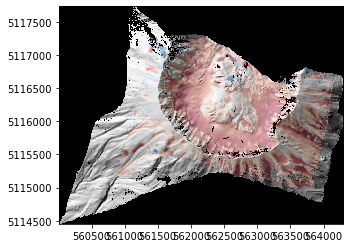

In [24]:
fig,ax = plt.subplots()
ax.imshow(hs,cmap='gray',extent=fig_extent,alpha=1)
dh = ax.imshow(-1*snow_depth,clim=(-15,15),cmap='RdBu',alpha=0.4,extent=fig_extent)
#plot_ar(-1*snow_depth,ax,(-15,15),cmap='RdBu',label='Elevation change (m)',cbar=True,alpha=0.6,extent=fig_extent)

(560007.0, 564297.0) (5114453.0, 5117733.0)


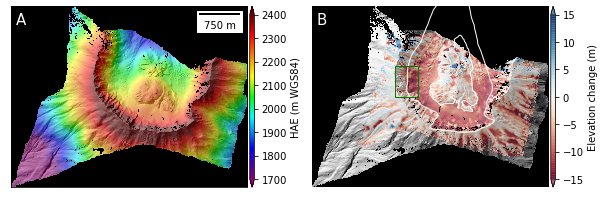

In [25]:
fig,ax = plt.subplots(1,2,figsize=(8.5,3.6))
clim_dem = (1700,2400)
pltlib.iv(iolib.ds_getma(dem_ds_list[0]),ds=dem_ds_list[0],ax=ax[0],scalebar=True,hillshade=True,label='HAE (m WGS84)',clim=clim_dem)

ax[1].imshow(hs,cmap='gray',extent=fig_extent)
plot_ar(-1*snow_depth,ax[1],(-15,15),cmap='RdBu',label='Elevation change (m)',cbar=True,alpha=0.6,extent=fig_extent)
ax[1].axis('off')
crater_glacier = crater_glacier.to_crs(dem_ds_list[0].GetProjection())
crater_glacier.plot(ax=ax[1],edgecolor='white',facecolor='None')
ax[1].set_xlim(fig_extent[0],fig_extent[1])
ax[1].set_ylim(fig_extent[2],fig_extent[3])
#st_helens_gdf.plot(ax=ax[1],facecolor='None',edgecolor='red')
#ax[1].set_xlim(extent[0],extent[2])
#ax[1].set_ylim(extent[1],extent[3])
plt.tight_layout()
someX,someY = [0.45,0.6]
poly = Rectangle((someX - .1, someY - .1), 0.1, 0.17, fill=None, alpha=1,color='green',transform=ax[1].transAxes)
#ax[1].add_patch(Rectangle((someX - .1, someY - .1), 150, 250, fill=None, alpha=1,color='green'))
ax[1].add_patch(poly)
xlima = ax[1].get_xlim()
ylima = ax[1].get_ylim()
print(xlima,ylima)
ax[0].text(0.020,0.9,'A',
    color='white', fontsize=15,transform=ax[0].transAxes)
ax[1].text(0.020,0.9,'B',
    color='white', fontsize=15,transform=ax[1].transAxes)
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'Figure6.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])
#fig.savefig('/nobackup/sbhusha1/agu/snow_depth3.jpg',dpi=300,pad_inches=0.1,bbox_inches='tight')

# Bonus Analysis

In [19]:
def gdaldem(ds,producttype='slope',returnma=True):
    dem_p_ds = gdal.DEMProcessing('',ds,producttype,format='MEM')
    ma = iolib.ds_getma(dem_p_ds)
    if returnma:
        out = ma
    else:
        out = dem_p_ds
    return out

In [19]:
slope_map_snow_off = gdaldem(poster_ds_list[1])
slope_map_snow_on = gdaldem(poster_ds_list[5])

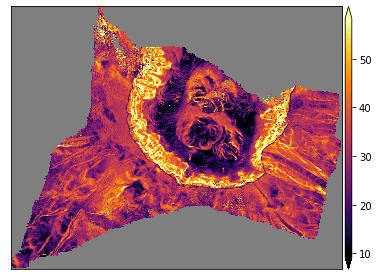

In [21]:
fig,ax = plt.subplots()
pltlib.iv(slope_map_snow_off,cmap='inferno',ax=ax)

In [ ]:
minx, maxx= list(malib.calcperc(E_masked, perc=(0.01, 99.99)))
minx = np.floor(minx/bin_width) * bin_width
maxx = np.ceil(maxx/bin_width) * bin_width
#Compute bin edges and centers
xedges = np.arange(minx, maxx + bin_width, bin_width)
xcenters = bin_edges[:-1] + np.diff(bin_edges)/2.0
 #Define min and max elevation
miny, maxy= list(malib.calcperc(dh_dt_masked, perc=(0.01, 99.99)))
#miny=-5
#maxy=+5
miny = np.floor(miny/0.02) * 0.02
maxy = np.ceil(maxy/0.02) * 0.02
#Compute bin edges and centers
yedges = np.arange(miny, maxy + 0.02, 0.02)
ycenters = bin_edges[:-1] + np.diff(bin_edges)/2.0

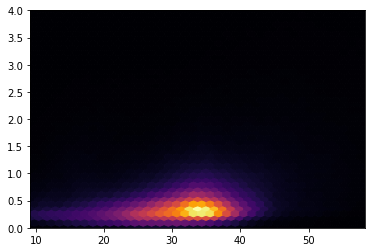

In [28]:
f,ax = plt.subplots()
plot_hexbin(slope_map_snow_off,snow_off_nmad,ax=ax,ylim=(0,4),gridsize=40)

In [29]:
def plothist(ax, x, y, xlim, ylim, log=False):
    bins = (100, 100)
    #Generate and apply a common mask for the DEM and the elevation change arrays
    common_mask = ~(malib.common_mask([x,y]))
    x = x[common_mask]
    y = y[common_mask]
    H, xedges, yedges = np.histogram2d(x,y,range=[xlim,ylim],bins=bins)
    H = np.rot90(H)
    H = np.flipud(H)
    #Mask any bins with zero count
    Hmasked = np.ma.masked_where(H==0,H)
    H_clim = malib.calcperc(Hmasked, (5,95))
    if log:
        import matplotlib.colors as colors
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',norm=colors.LogNorm(vmin=H_clim[0],vmax=H_clim[1]))
    else:
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',vmin=H_clim[0],vmax=H_clim[1])
    #Plot a line for the max values in each elevation band
    Hmax_idx = np.ma.argmax(Hmasked, axis=0)
    ymax = (yedges[:-1]+np.diff(yedges))[Hmax_idx]

<IPython.core.display.Javascript object>


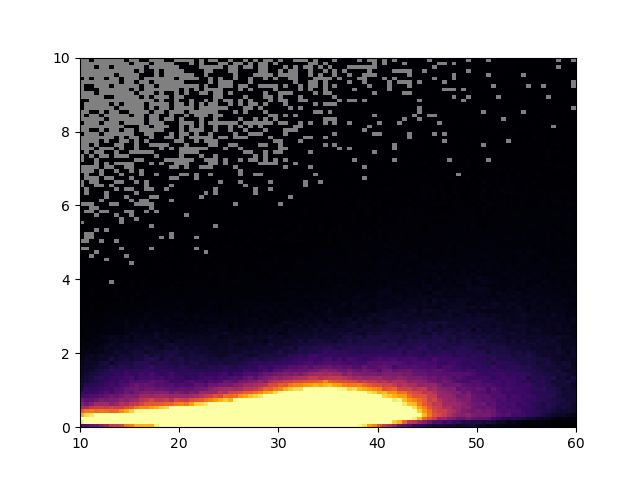

In [33]:
f,ax = plt.subplots()
plothist(ax,slope_map_snow_off,snow_off_nmad,xlim=(10,60),ylim=(0,10))

In [34]:
common_mask = malib.common_mask([slope_map,snow_depth])
snow_y = np.ma.array(-1*snow_depth,mask=common_mask)
slope_x = np.ma.array(slope_map,mask=common_mask)

In [35]:
snow_y.shape

(1510, 2086)

In [36]:
slope_x.shape

(1510, 2086)

In [37]:
np.ma.compressed(slope_x).shape

(1115121,)

In [38]:
np.ma.compressed(snow_y).shape

(1115121,)

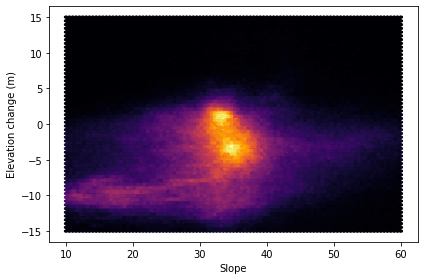

In [39]:
fig,ax = plt.subplots()
ax.hexbin(np.ma.compressed(slope_x),np.ma.compressed(snow_y),cmap='inferno',gridsize=100,extent=[10,60,-15,15])
ax.set_ylabel('Elevation change (m)')
ax.set_xlabel('Slope')
plt.tight_layout()

In [22]:
def plot_hexbin(x,y,ax,xlim=None,ylim=None,gridsize=100):
    c_mask = malib.common_mask([x,y])
    x = np.ma.array(x,mask=c_mask)
    y = np.ma.array(y,mask=c_mask)
    x_com = np.ma.compressed(x)
    y_com = np.ma.compressed(y)
    if not xlim:
        xlim = np.percentile(x_com,(2,98))
    if not ylim:
        ylim = np.percentile(y_com,(2,98))
    ax.hexbin(x_com,y_com,cmap='inferno',gridsize=gridsize,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])

In [41]:
aspect_map = gdaldem(dem_ds_list[0],'aspect')

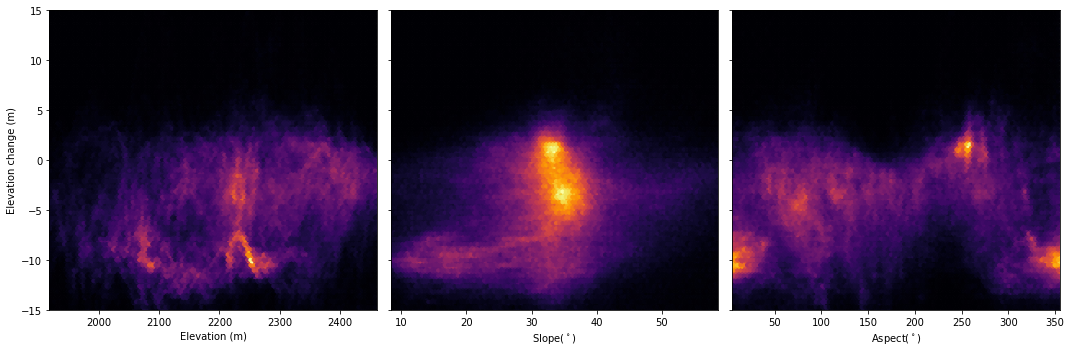

In [42]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
plot_hexbin(iolib.ds_getma(dem_ds_list[0]),-1*snow_depth,ax=ax[0],ylim=[-15,15])
plot_hexbin(slope_map,-1*snow_depth,ax=ax[1],ylim=[-15,15])
plot_hexbin(aspect_map,-1*snow_depth,ax=ax[2],ylim=[-15,15])
ax[0].set_xlabel('Elevation (m)')
ax[1].set_xlabel('Slope($^\circ$)')
ax[2].set_xlabel('Aspect($^\circ$)')
ax[0].set_ylabel('Elevation change (m)')
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'Bonus_fig.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])


# Supplementary Figure

/nobackup/sbhusha1/sw/miniconda3/envs/bhushan_PY3/lib/python3.6/site-packages/matplotlib/image.py:443: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


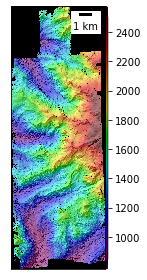

In [52]:
indi_align_dem = '/nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/indi_align_composite/total_composite_median.tif'
fig,ax = plt.subplots()
pltlib.iv_fn(indi_align_dem,ax=ax,full=True,hillshade=True)

In [53]:
refdem = '/nobackupp2/sbhusha1/skysat/rainier_allgood_mos-tile-0.tif'
ds_list = warplib.memwarp_multi_fn([indi_align_dem,refdem])
indi_align_ma,ref_ma = [iolib.ds_getma(x) for x in ds_list]



Warping all inputs to the following:
Resolution: 2.0
Extent: [583553.0, 5179210.73035901, 591059.0, 5199135.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackupp2/sbhusha1/skysat/proc_rainier/final_paper_submission/mapprojected_srtm_mgm_dems/indi_align_composite/total_composite_median.tif
nl: 9962 ns: 3753 res: 2.000
2 of 2: /nobackupp2/sbhusha1/skysat/rainier_allgood_mos-tile-0.tif
nl: 9962 ns: 3753 res: 2.000


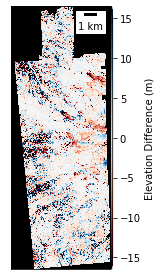

In [54]:
fig,ax = plt.subplots()
pltlib.iv(indi_align_ma-ref_ma,label='Elevation Difference (m)',scalebar=True,ds=ds_list[0],ax=ax,cmap='RdBu',clim=(-15,15))
outfig = os.path.join(master_fig_dir,'SF1.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])


In [55]:
fall_rpc_dir = '/nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/rpc_dem_non_ortho_block/'
peak_rpc_dir = '/nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/planet_rpc_dems_sam_in_10_normal_texture/'
fn_sup_list = [os.path.join(fall_rpc_dir,x) for x in ['median.tif','count.tif','nmad_mos.tif']]+[os.path.join(peak_rpc_dir,x) for x in ['median_mos.tif','count_mos.tif','nmad_mos.tif']]

poster_ds_list = warplib.memwarp_multi_fn(fn_sup_list,extent='union',res=2)
extent = geolib.ds_extent(poster_ds_list[1])
extent = [extent[0],extent[2],extent[1],extent[3]]


Warping all inputs to the following:
Resolution: 2.0
Extent: [559886.0, 5114222.0, 564418.0, 5117922.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 6: /nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/rpc_dem_non_ortho_block/median.tif
nl: 1850 ns: 2266 res: 2.000
2 of 6: /nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/rpc_dem_non_ortho_block/count.tif
nl: 1850 ns: 2266 res: 2.000
3 of 6: /nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/rpc_dem_non_ortho_block/nmad_mos.tif
nl: 1850 ns: 2266 res: 2.000
4 of 6: /nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/planet_rpc_dems_sam_in_10_normal_texture/median_mos.tif
nl: 1850 ns: 2266 res: 2.000
5 of 6: /nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/planet_rpc_dems_sam_in_10_normal_texture/count_mos.tif
nl: 1850 ns: 2266 res: 2.000
6 of 6: /nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/planet_rpc_dems_

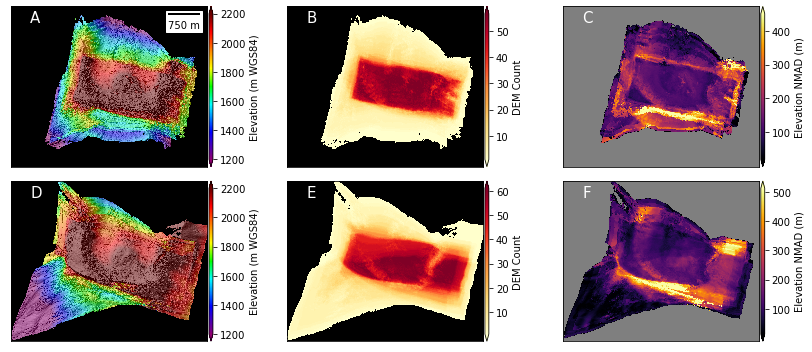

In [57]:
fig,ax = plt.subplots(2,3,figsize=(12,5))
axa = ax.ravel()
cmap_count = 'YlOrRd'
cmap_nmad = 'inferno'
clim_dem = (1200,2200)
pltlib.iv(iolib.ds_getma(poster_ds_list[0]),ds=poster_ds_list[0],ax=axa[3],scalebar=False,hillshade=True,label='Elevation (m WGS84)',clim=clim_dem)
pltlib.iv(iolib.ds_getma(poster_ds_list[1]),ax=axa[4],scalebar=False,label='DEM Count',cmap=cmap_count)
pltlib.iv(iolib.ds_getma(poster_ds_list[2]),ax=axa[5],scalebar=False,label='Elevation NMAD (m)',cmap=cmap_nmad)
pltlib.iv(iolib.ds_getma(poster_ds_list[3]),ds=poster_ds_list[3],ax=axa[0],scalebar=True,hillshade=True,label='Elevation (m WGS84)',clim=clim_dem)
pltlib.iv(iolib.ds_getma(poster_ds_list[4]),ax=axa[1],scalebar=False,label='DEM Count',cmap=cmap_count)
pltlib.iv(iolib.ds_getma(poster_ds_list[5]),ax=axa[2],scalebar=False,label='Elevation NMAD (m)',cmap=cmap_nmad)
axa[1].text(0.1,0.9,'B',
    color='white', fontsize=15,transform=axa[1].transAxes)
axa[2].text(0.1,0.9,'C',
    color='white', fontsize=15,transform=axa[2].transAxes)
axa[0].text(0.1,0.9,'A',
    color='white', fontsize=15,transform=axa[0].transAxes)
axa[4].text(0.1,0.9,'E',
    color='white', fontsize=15,transform=axa[4].transAxes)
axa[5].text(0.1,0.9,'F',
    color='white', fontsize=15,transform=axa[5].transAxes)
axa[3].text(0.1,0.9,'D',
    color='white', fontsize=15,transform=axa[3].transAxes)
#axa[1].set_ylabel('4/20/19 (Snow-on)')
#axa[3].set_ylabel('10/1/19 (Snow-off)')
                      
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'SF2.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])


In [10]:
rpc_snow_on_nmad = iolib.ds_getma(poster_ds_list[2])
rpc_snow_off_nmad = iolib.ds_getma(poster_ds_list[5])

malib.calcperc(rpc_snow_off_nmad,(1,99))

(1.7662524652481133, 509.71474304199256)

In [11]:
malib.calcperc(rpc_snow_on_nmad,(1,99))

(7.0105384349822994, 571.5710815429688)

In [13]:
malib.get_stats_dict(rpc_snow_on_nmad)

{'count': 2083171,
 'min': -101.28812408447266,
 'max': 791.1691284179688,
 'ptp': 892.457275390625,
 'mean': 153.62714543966692,
 'std': 119.00456586148707,
 'nmad': 85.90305793304442,
 'med': 126.02918243408203,
 'median': 126.02918243408203,
 'p16': 51.93246841430664,
 'p84': 242.2696502685547,
 'spread': 95.16859092712403,
 'mode': 28.52320098876953}

### MVS figure


Warping all inputs to the following:
Resolution: 2.0
Extent: [560815.0, 5114965.0, 564223.0, 5117349.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/mvs_14_1/median_mos.tif
nl: 1192 ns: 1704 res: 2.000
2 of 2: /nobackup/sbhusha1/skysat_video/Mt.St.Helens/output/video/mgm_sam_interval_10_high/median_mos.tif
nl: 1192 ns: 1704 res: 2.000


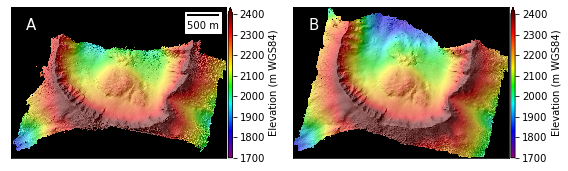

In [42]:
mvs_fn = '/nobackupp2/sbhusha1/skysat_video/Mt.St.Helens/output/video/mvs_14_1/median_mos.tif'
clim_dem = (1700,2400)
default_peak = fall_fn_list[0]
ds_list = warplib.memwarp_multi_fn((mvs_fn,default_peak),extent='union')
mvs_ma = iolib.ds_getma(ds_list[0])
peak_ma = iolib.ds_getma(ds_list[1])
f,ax = plt.subplots(1,2,figsize=(8,6))
pltlib.iv(mvs_ma,ax=ax[0],ds=ds_list[0],hillshade=True,scalebar=True,label='Elevation (m WGS84)',clim=clim_dem)
pltlib.iv(peak_ma,ax=ax[1],ds=ds_list[1],hillshade=True,scalebar=False,label='Elevation (m WGS84)',clim=clim_dem)
ax[1].text(0.07,0.85,'B',
    color='white', fontsize=15,transform=ax[1].transAxes)
ax[0].text(0.07,0.85,'A',
    color='white', fontsize=15,transform=ax[0].transAxes)
plt.tight_layout()
outfig = os.path.join(master_fig_dir,'SF3.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])

## Supplementary Figure 4: Video multipanel

In [37]:
! ls /nobackup/sbhusha1/skysat_video/pfe_plot/gm

gm_count.tif
gm_med.tif
gm_nmad.tif
gm_ortho.tif
run-trans_source-DEM_gm_8m-tile-0_nuth_x+24.18_y+12.08_z+0.74_align_diff_filt.tif


In [38]:
gm_set = [os.path.join('/nobackup/sbhusha1/skysat_video/pfe_plot/gm/',x) for x in ['gm_ortho.tif','gm_med.tif','gm_count.tif','gm_nmad.tif']]
# add ortho
oso_set = [os.path.join('/nobackup/sbhusha1/skysat_video/agu_analysis/oso_pfe/',x) for x in ['oso_ortho.tif','oso_med_aligned_wv.tif','oso_count.tif','oso_nmad_5_8.tif']]
imja_set = ['/nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/wt_avg_ortho.tif','/nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/aligned2himat_wv/run-trans_reference-DEM.tif']+[os.path.join('/nobackup/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/',x) for x in ['imja_count.tif','imja_nmad.tif']]
breckenridge_set = ['/nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/breckenridge_ortho.tif']+[os.path.join('/nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/stereo_dems/',x) for x in ('median_mos.tif','count_mos.tif','nmad_mos.tif')]
tahoma_set = ['/nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/orthoimage.tif']+[os.path.join('/nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/stereo_dems/',x) for x in ('median_mos.tif','count_mos.tif','nmad_mos.tif')]

In [20]:
tahoma_ds_set = warplib.memwarp_multi_fn(tahoma_set,extent='union',res='max')


Warping all inputs to the following:
Resolution: 2.0
Extent: [588644.7546687722, 5184384.616447985, 592042.2695687413, 5186295.55485934]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/orthoimage.tif
nl: 955 ns: 1699 res: 2.000
2 of 4: /nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/stereo_dems/median_mos.tif
nl: 955 ns: 1699 res: 2.000
3 of 4: /nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/stereo_dems/count_mos.tif
nl: 955 ns: 1699 res: 2.000
4 of 4: /nobackup/sbhusha1/skysat_video/Mt_st_helens_flood_burst/output/video/stereo_dems/nmad_mos.tif
nl: 955 ns: 1699 res: 2.000


In [53]:
breckenridge_ds_set = warplib.memwarp_multi_fn(breckenridge_set,extent='union',res='max')


Warping all inputs to the following:
Resolution: 4.0
Extent: [1437658.0, 4424382.0, 1442434.7973067164, 4429562.003096402]
Projection: '+proj=utm +zone=11 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/breckenridge_ortho.tif
nl: 1295 ns: 1194 res: 4.000
2 of 4: /nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/stereo_dems/median_mos.tif
nl: 1295 ns: 1194 res: 4.000
3 of 4: /nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/stereo_dems/count_mos.tif
nl: 1295 ns: 1194 res: 4.000
4 of 4: /nobackup/sbhusha1/skysat_video/Breckenridge_video/output/video/stereo_dems/nmad_mos.tif
nl: 1295 ns: 1194 res: 4.000


In [9]:
oso_ds_set = warplib.memwarp_multi_fn(oso_set,extent='union',res='max')


Warping all inputs to the following:
Resolution: 4.0
Extent: [583486.7084603093, 5347029.540464923, 587510.9664945604, 5349970.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /nobackup/sbhusha1/skysat_video/agu_analysis/oso_pfe/oso_ortho.tif
nl: 735 ns: 1006 res: 4.000
2 of 4: /nobackup/sbhusha1/skysat_video/agu_analysis/oso_pfe/oso_med_aligned_wv.tif
nl: 735 ns: 1006 res: 4.000
3 of 4: /nobackup/sbhusha1/skysat_video/agu_analysis/oso_pfe/oso_count.tif
nl: 735 ns: 1006 res: 4.000
4 of 4: /nobackup/sbhusha1/skysat_video/agu_analysis/oso_pfe/oso_nmad_5_8.tif
nl: 735 ns: 1006 res: 4.000


In [12]:
imja_set

['/nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/wt_avg_ortho.tif',
 '/nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/aligned2himat_wv/run-trans_reference-DEM.tif',
 ('/nobackup/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/imja',
  'oso_count.tif'),
 ('/nobackup/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/imja',
  'oso_nmad.tif')]

In [21]:
imja_ds_set = warplib.memwarp_multi_fn(imja_set,extent='union',res='max')


Warping all inputs to the following:
Resolution: 4.0
Extent: [490046.0, 3084902.0, 493314.0, 3087098.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/wt_avg_ortho.tif
nl: 549 ns: 817 res: 4.000
2 of 4: /nobackupp2/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/aligned2himat_wv/run-trans_reference-DEM.tif
nl: 549 ns: 817 res: 4.000
3 of 4: /nobackup/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/imja_count.tif
nl: 549 ns: 817 res: 4.000
4 of 4: /nobackup/sbhusha1/skysat_video/Imja/output/video/imja_dems_original/imja_nmad.tif
nl: 549 ns: 817 res: 4.000


In [39]:
gm_ds_set = warplib.memwarp_multi_fn(gm_set,extent='union',res='max')


Warping all inputs to the following:
Resolution: 4.248341486255222
Extent: [742397.9411286542, 4321864.575804381, 745965.6936607382, 4324809.9445460895]
Projection: '+proj=utm +zone=12 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 4: /nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_ortho.tif
nl: 693 ns: 840 res: 4.248
2 of 4: /nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_med.tif
nl: 693 ns: 840 res: 4.248
3 of 4: /nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_count.tif
nl: 693 ns: 840 res: 4.248
4 of 4: /nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_nmad.tif
nl: 693 ns: 840 res: 4.248


In [34]:
gm_set

['/nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_ortho.tif',
 '/nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_median.tif',
 '/nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_count.tif',
 '/nobackup/sbhusha1/skysat_video/pfe_plot/gm/gm_nmad.tif']

<IPython.core.display.Javascript object>


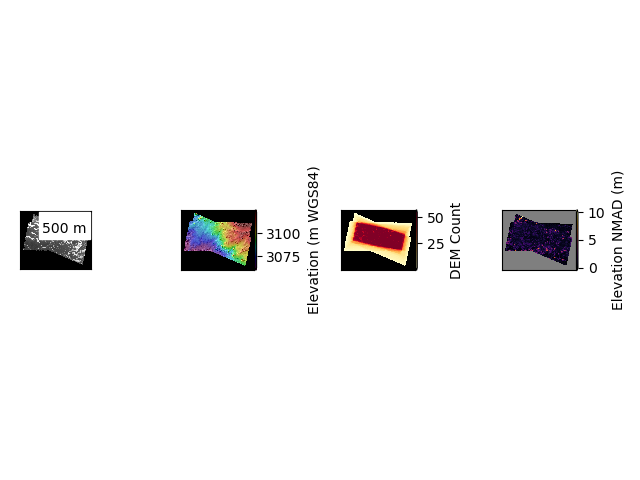

In [47]:
f,ax = plt.subplots(1,4)
extent_gm = geolib.ds_extent(gm_ds_set[1])
extent_gm = [extent_gm[0],extent_gm[2],extent_gm[1],extent_gm[3]]
plot_video_out(gm_ds_set,ax,extent_gm,(0,1000))

<IPython.core.display.Javascript object>


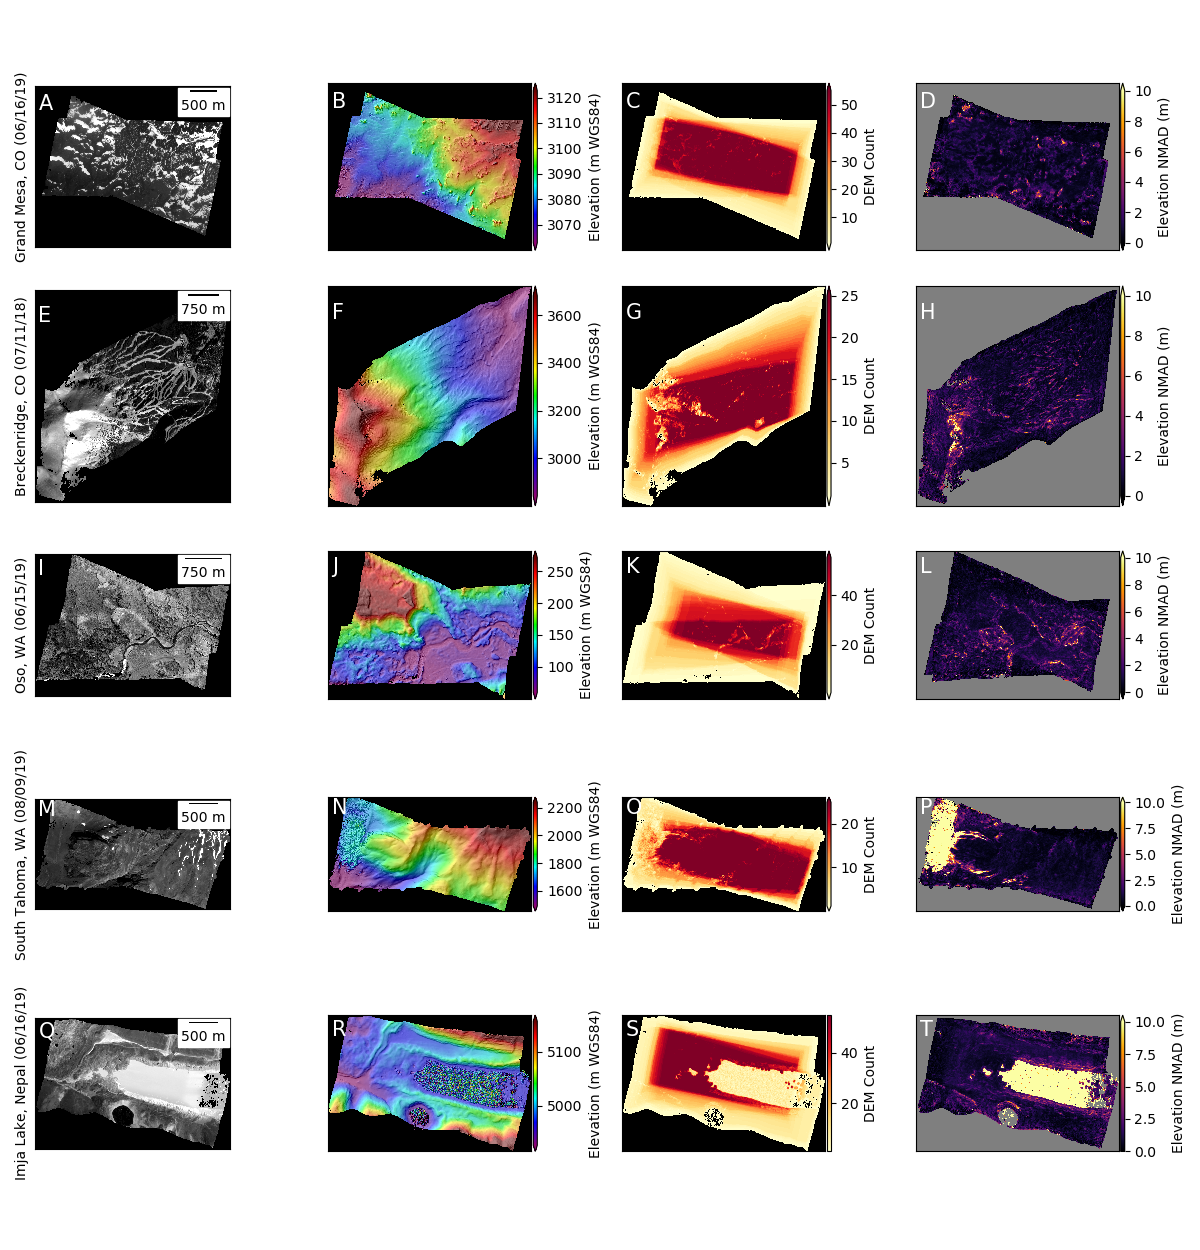

In [64]:
f,ax = plt.subplots(5,4,figsize=(12,12.5))
axa = ax.ravel()
axa_gm = axa[0:4]
axa_breckenridge = axa[4:8]
axa_oso = axa[8:12]
axa_tahoma = axa[12:16]
axa_imja = axa[16:20]
plot_video_out(gm_ds_set,axa_gm,(150,1000))
plot_video_out(breckenridge_ds_set,axa_breckenridge,clim=(500,2500))
plot_video_out(oso_ds_set,axa_oso,clim=(150,450))
plot_video_out(tahoma_ds_set,axa_tahoma)
plot_video_out(imja_ds_set,axa_imja,clim=(100,650))
axa[0].set_ylabel('Grand Mesa, CO (06/16/19)')
axa[4].set_ylabel('Breckenridge, CO (07/11/18)')
axa[8].set_ylabel('Oso, WA (06/15/19)')
axa[12].set_ylabel('South Tahoma, WA (08/09/19)')
axa[16].set_ylabel('Imja Lake, Nepal (06/16/19)')
plt.tight_layout()
import string
label_itereator = string.ascii_uppercase
for idx,axes in enumerate(axa):
    axes.text(0.02,0.85,label_itereator[idx],color='white',fontsize=15,transform=axes.transAxes)
outfig = os.path.join(master_fig_dir,'SF4.jpg')
plt.savefig(outfig,dpi=universal_fig_opt['dpi'],bbox_inches=universal_fig_opt['bbox_inches'],pad_inches=universal_fig_opt['pad_inches'])

In [51]:
axa_gm

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aab486dc860>,
      dtype=object)

# Stats for elevation difference static

In [28]:
peak_ref = '/nobackup/sbhusha1/skysat_video/paper_analysis/20190428_dg_mgm_peak_non_glacier_shpclip_registered_dx_0.11_dy_0.4_dz_0.95.tif'
peak_video = '/nobackup/sbhusha1/skysat_video/paper_analysis/20190420_peak_filtered_correction_direc_updated_crater_nmad5_count2-trans_source-DEM.tif'

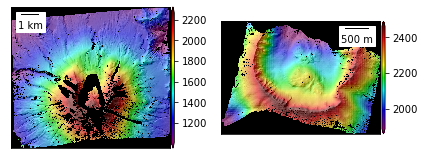

In [29]:
fig,ax = plt.subplots(1,2)
pltlib.iv_fn(peak_ref,ax=ax[0],hillshade=True)
pltlib.iv_fn(peak_video,ax=ax[1],hillshade=True)

In [30]:
peak_coreg_list = warplib.memwarp_multi_fn([peak_ref,peak_video])
ref_ma = iolib.ds_getma(peak_coreg_list[0])
source_ma = iolib.ds_getma(peak_coreg_list[1])



Warping all inputs to the following:
Resolution: 2.0
Extent: [560835.0, 5114995.0, 564143.0, 5117341.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/20190428_dg_mgm_peak_non_glacier_shpclip_registered_dx_0.11_dy_0.4_dz_0.95.tif
nl: 1173 ns: 1654 res: 2.000
2 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/20190420_peak_filtered_correction_direc_updated_crater_nmad5_count2-trans_source-DEM.tif


In [31]:
diff = ref_ma-source_ma
malib.get_stats_dict(diff)

{'count': 581805,
 'min': -148.52001953125,
 'max': 134.058837890625,
 'ptp': 282.578857421875,
 'mean': -0.4379213632490563,
 'std': 10.343976053856439,
 'nmad': 2.4032526123046876,
 'med': 0.3341064453125,
 'median': 0.3341064453125,
 'p16': -3.27197265625,
 'p84': 2.590087890625,
 'spread': 2.9310302734375,
 'mode': 0.799560546875}

In [133]:
min_ref = '/nobackup/sbhusha1/skysat_video/paper_analysis/mos_8m_all_toamask-tile-0_non_glacier_shpclip.tif'
min_video = '/nobackup/sbhusha1/skysat_video/paper_analysis/20191001_fall_filtered_correction_direc_updated_crater_nmad5_count2-trans_reference-DEM.tif'

<IPython.core.display.Javascript object>


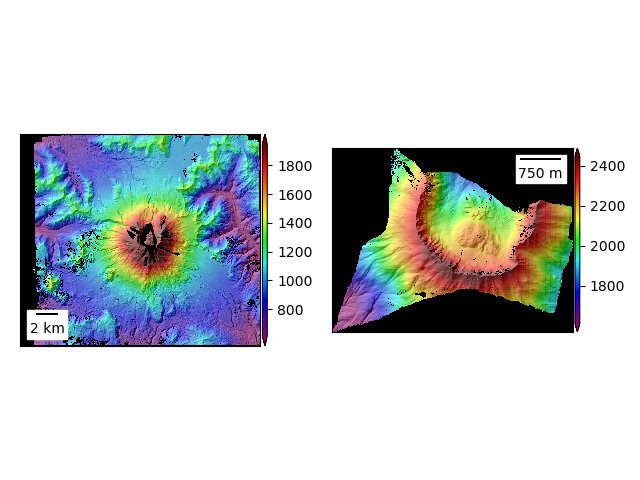

In [134]:
fig,ax = plt.subplots(1,2)
pltlib.iv_fn(min_ref,ax=ax[0],hillshade=True)
pltlib.iv_fn(min_video,ax=ax[1],hillshade=True)

In [135]:
min_coreg_list = warplib.memwarp_multi_fn([min_ref,min_video])
min_ma = iolib.ds_getma(min_coreg_list[0])
min_video_ma = iolib.ds_getma(min_coreg_list[1])



Warping all inputs to the following:
Resolution: 8.0
Extent: [560007.0, 5114453.0, 564297.0, 5117733.0]
Projection: '+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/mos_8m_all_toamask-tile-0_non_glacier_shpclip.tif
nl: 410 ns: 536 res: 8.000
2 of 2: /nobackup/sbhusha1/skysat_video/paper_analysis/20191001_fall_filtered_correction_direc_updated_crater_nmad5_count2-trans_reference-DEM.tif
nl: 410 ns: 536 res: 8.000


In [136]:
diff = min_ma-min_video_ma
malib.get_stats_dict(diff)

{'count': 80891,
 'min': -39.414306640625,
 'max': 40.315673828125,
 'ptp': 79.72998046875,
 'mean': 0.5032946066721924,
 'std': 4.226275876778294,
 'nmad': 2.2296914062499997,
 'med': -0.228759765625,
 'median': -0.228759765625,
 'p16': -2.190673828125,
 'p84': 3.5494873046874904,
 'spread': 2.870080566406245,
 'mode': -1.339111328125}

In [58]:
np.sqrt(2.69**2+2.02**2+1.01**2)

3.5123496409099135

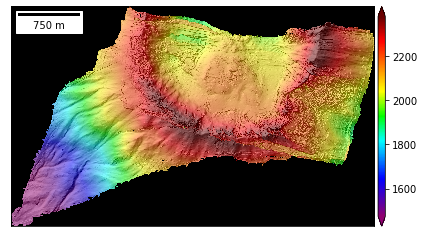

In [60]:
mvs = '/nobackupp2/sbhusha1/skysat_video/fall_sthelens_video/output/video/final_mapprojected_analysis/14_pair_mvs_final_mapprojected_analysis/mean_mos.tif'
fig,ax = plt.subplots()
pltlib.iv_fn(mvs,hillshade=True,full=True,ax=ax)